In [1]:
import pandas as pd
import numpy as np

from collections import deque

import utils as u

import pickle
import time

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from scipy.stats import entropy

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline

# vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# feature selectors
from sklearn.feature_selection import SelectKBest, chi2

# scalers
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression

# samplers
from imblearn.under_sampling import TomekLinks

# calibration
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df = pd.read_pickle('../pandas/lemma_delivered_merged_df.pkl')

In [3]:
#df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_labeled_vocab.pkl')
df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_full_vocab.pkl')
df['is_nn'] = pd.read_pickle('../pandas/is_nn_full.pkl')
df['is_trash'] = pd.read_pickle('../pandas/is_trash_full.pkl')

In [4]:
labeled_corpus = df[(df['agg_label'] != -1) & (df['is_nn'] == False)]
unlabeled_corpus = df[(df['agg_label'] == -1) & (df['is_nn'] == False) & (df['is_trash'] == False)]

target = 'agg_label'
text = 'lemma_delivered'
fasttext = 'ft'
numeric = ['raw_len', 'raw_word_count']

In [5]:
train_X, vali_X, train_y, vali_y = train_test_split(
    labeled_corpus,
    labeled_corpus[target],
    test_size=0.4,
    random_state=1,
    stratify=labeled_corpus[target])

test_X, validation_X, test_y, validation_y = train_test_split(
    vali_X,
    vali_y,
    test_size=0.5,
    random_state=1,
    stratify=vali_y)

In [6]:
# models
clf_LinearSVC = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01})
baseline_model = {
    'title': 'baseline_model',
    'features': ('Text+FT', {'text': text, 'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    #'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

quick_svm_model = {
    'title': 'quick_svm_model',
    'features': ('Text+FT', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

clf_ComplementNB = ComplementNB(**{'alpha': 0.2})
quick_model = {
    'title': 'quick_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'cv': 3}),
}

clf_LogisticRegression = LogisticRegression(**{'solver': 'saga', 'tol': 0.0001, 'C': 8, 'n_jobs': -1, 'random_state': 1})
log_model = {
    'title': 'log_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LogisticRegression', CalibratedClassifierCV, {'base_estimator': clf_LogisticRegression, 'method': 'isotonic', 'cv': 3}),
}

wordembed_model = {
    'title': 'wordembed_model',
    'features': ('FT', {'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', u.PassThrough, {}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    #'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

In [247]:
class FastTextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        return np.stack(df[self.col].to_numpy())

def modeller(data, model):

    features = []

    if 'text' in model['features'][1]:
        features.append(
            ('text', Pipeline([
                ('article', u.ColumnSelector(model['features'][1]['text'])),
                ('vectorizer', model['vectorizer'][1](**model['vectorizer'][2])),
            ]))
        )

    if 'ft' in model['features'][1]:
        features.append(
            ('embeddings', Pipeline([
                ('ft', FastTextSelector(model['features'][1]['ft'])),
                ('scaler', model['scaler'][1](**model['scaler'][2])),
            ]))
        )

    model = Pipeline([
        ('features', FeatureUnion(features)),
        ('sampler', model['sampler'][1](**model['sampler'][2])),
        ('classifier', model['classifier'][1](**model['classifier'][2]))
    ])
    

    model.fit(data['train_X'], data['train_y'])
    preds = model.predict(data['validation_X'])
    probs = model.predict_proba(data['validation_X'])
    
    metrics = {}
    
    if 'validation_y' in data:
        metrics['acc'] = accuracy_score(data['validation_y'], preds)
        metrics['prec'], metrics['reca'], metrics['fsco'], _ = precision_recall_fscore_support(data['validation_y'], preds, average='macro')
        #print(acc, prec, reca, fsco)
    
    return preds, probs, metrics

def get_entropy_train_x(t_X, t_y, scaler):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        t_X,
        t_y,
        test_size=0.5,
        random_state=1,
        stratify=t_y)
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': train_b_X,
        'validation_y': train_b_y
    }
    
    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': train_a_X,
        'validation_y': train_a_y
    }
    
    preds_b, probs_b, metric_b = modeller(data_a, baseline_model)
    preds_a, probs_a, metric_a = modeller(data_b, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)
    #dynamic_thresholds_b = get_dynamic_threshold(preds_a, prob_a, scaler)
    
    print(dynamic_threshold)

    entropy_a = entropy(probs_a.T)
    entropy_b = entropy(probs_b.T)
    
    entropy_ab = np.concatenate([entropy_a, entropy_b])
    
    mean_entropy = entropy_ab.mean() + ((entropy_ab.max() - entropy_ab.mean())/2)

    mask_below_a = entropy_a <= mean_entropy
    mask_below_b = entropy_b <= mean_entropy
    
    mask_above_a = entropy_a > mean_entropy
    mask_above_b = entropy_b > mean_entropy
    
    index_below = train_a_X.loc[mask_below_a].index.union(train_b_X.loc[mask_below_b].index)
    index_above = train_a_X.loc[mask_above_a].index.union(train_b_X.loc[mask_above_b].index)

    #probs_a_sorted = np.sort(probs_a)
    #probs_b_sorted = np.sort(probs_b)
    #margin_a = 1 - (probs_a_sorted[:,-1] + probs_a_sorted[:,-2])
    #margin_b = 1 - (probs_b_sorted[:,-1] + probs_b_sorted[:,-2])
    #margin = np.concatenate([margin_a, margin_b])

    return index_below, index_above, dynamic_threshold


def get_entropy_co_trained(data, index_below, index_above, dynamic_threshold, threshold=0.9, scaler=0.93):

    data_a = {
        'train_X': data['train_X'].loc[index_below],
        'train_y': data['train_y'].loc[index_below],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].loc[index_above],
        'train_y': data['train_y'].loc[index_above],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_a, baseline_model)
    preds_b, probs_b, _ = modeller(data_b, baseline_model)
    
    #dynamic_threshold_a = get_dynamic_threshold(preds_b, np.amax(probs_a, axis=1), scaler)
    #dynamic_threshold_b = get_dynamic_threshold(preds_b, np.amax(probs_b, axis=1), scaler)
    #print(dynamic_threshold_a)
    #print(dynamic_threshold_b)
    
    print("Mean entropy a: " + str(entropy(probs_a.T).mean()))
    print("Mean entropy b: " + str(entropy(probs_b.T).mean()))
    
    print("Mean probs a: " + str(np.amax(probs_a, axis=1).mean()) + ", Max probs a: " + str(np.amax(probs_a, axis=1).max()))
    print("Mean probs b: " + str(np.amax(probs_b, axis=1).mean()) + ", Max probs b: " + str(np.amax(probs_b, axis=1).max()))
    
    pred_mask = preds_a == preds_b
    
    print("Number of equals: " + str(pred_mask.sum()))
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold
    
    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))
    
    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)
    
    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)
    
    print("Mask length: " + str(mask.sum()))
    
    return mask, preds_a

def get_dynamic_threshold(preds, probs, scaler=0.9):
    
    dynamic_thresholds = {}
    for l in np.unique(preds):
        if l in [12]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.000)
        elif l in [3]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.000)
        else:
            dynamic_thresholds[l] = probs[preds == l].max() * scaler
        
    return dynamic_thresholds

def get_dynamic_threshold_mask(preds, probs, dynamic_thresholds):
        
    mask = []
    for i in range(preds.shape[0]):
        if probs[i] >= dynamic_thresholds[preds[i]]:
            mask.append(True)
        else:
            mask.append(False)
    
    return np.array(mask)


def get_model(data, scaler=0.9):

    preds, probs, _ = modeller(data, baseline_model)

    prob = np.amax(probs, axis=1)
    
    dynamic_threshold = get_dynamic_threshold(preds, prob, scaler)
    
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)
    
    return mask, preds


def random_split(data, scaler=0.9, threshold=0.9):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        data['train_X'],
        data['train_y'],
        test_size=0.5,
        random_state=1,
        stratify=data['train_y'])
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a


def support_vector_split(data, scaler=0.9, threshold=0.9):
    
    vec = TfidfVectorizer(**{'lowercase': False, 'max_df': 0.25})
    vec_t_X = vec.fit_transform(data['train_X'][text])
    clf = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}).fit(vec_t_X, data['train_y'])
    decision_function = clf.decision_function(vec_t_X)
    support_vector_indices = np.where(np.amin(np.abs(decision_function), axis=1) <= 0.4)[0]
    not_support_vector_indices = [x for x in range(X.shape[0]) if x not in support_vector_indices]
    
    #display(data['train_y'].iloc[support_vector_indices].value_counts())
    #display(data['train_y'].iloc[not_support_vector_indices].value_counts())

    data_a = {
        'train_X': data['train_X'].iloc[support_vector_indices],
        'train_y': data['train_y'].iloc[support_vector_indices],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].iloc[not_support_vector_indices],
        'train_y': data['train_y'].iloc[not_support_vector_indices],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    #prob_mask_a = np.amax(probs_a, axis=1) > threshold
    #prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a



def basic_wrapper(scaler=0.9, threshold=0.9, iterations=10, sample_size=1000):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        if sample_size != False:
            sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)
        else:
            sample = unlabeled_corpus.drop(labels=sampled_indexes)
            #sample = validation_X.copy()
            
        data_sample = {
            'train_X': iter_data[0],
            'train_y': iter_data[1],
            'validation_X': sample
        }
            
        #index_below, index_above, dynamic_threshold = get_entropy_train_x(iter_data[0], iter_data[1], scaler)
        #mask, preds = get_entropy_co_trained(data_sample, index_below, index_above, dynamic_threshold, threshold=threshold)
        
        mask, preds = get_model(data_sample, scaler=scaler)
        
        #mask, preds = random_split(data_sample, scaler=scaler, threshold=threshold)
        
        #mask, preds = support_vector_split(data_sample, scaler=scaler, threshold=threshold)
        
        sample['preds'] = preds

        if mask.sum() > 0:
            
            iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds'], axis=1).loc[mask]])
            iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])

            sampled_indexes = sampled_indexes.union(sample.loc[mask].index)

            print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))
            
        else:
            print("No new samples!")
            if sample_size == False:
                break

    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        'validation_y': test_y,
    }
    
    test_preds, _, test_metrics = modeller(data_test, baseline_model)

    return sampled_indexes, iter_data, test_preds, test_metrics

In [253]:
sampled_indexes, iter_data, test_preds, test_metrics = basic_wrapper(scaler=0.98, threshold=0.88, iterations=10, sample_size=50000)

Iteration: 1
Total number of unlabeled added: 787
Iteration: 2
Total number of unlabeled added: 1583
Iteration: 3
Total number of unlabeled added: 2362
Iteration: 4
Total number of unlabeled added: 3091
Iteration: 5
Total number of unlabeled added: 3775
Iteration: 6
Total number of unlabeled added: 4378
Iteration: 7
Total number of unlabeled added: 5000
Iteration: 8
Total number of unlabeled added: 5555
Iteration: 9
Total number of unlabeled added: 6124
Iteration: 10
Total number of unlabeled added: 6670


In [254]:
test_metrics

{'acc': 0.7008317681781594,
 'prec': 0.6899116052139278,
 'reca': 0.6730150017237123,
 'fsco': 0.6785793297328615}

In [255]:
(iter_data[1].value_counts() - train_y.value_counts()).sort_values(ascending=False)

12    2984
3      773
16     596
10     435
6      315
8      255
20     206
15     180
17     104
4       98
9       86
14      79
13      64
19      62
5       58
7       57
23      52
26      44
25      40
24      39
1       34
93      25
91      20
2       19
92      17
18      16
21      12
dtype: int64

In [209]:
data = {
    'train_X': train_X,
    'train_y': train_y,
    'validation_X': test_X,
    'validation_y': test_y
}


preds, probs, metrics = modeller(data, baseline_model)
prob = np.amax(probs, axis=1)

In [210]:
metrics

{'acc': 0.7121008854306413,
 'prec': 0.7029552441523388,
 'reca': 0.6743213803721121,
 'fsco': 0.6848778768345123}

In [138]:
results = pd.DataFrame([], columns=[
        'ratio',
        'num_predictions',
        'min_label_predictions',
        'mean_label_predictions',
        'max_label_predictions',
        'num_labels_misclassified',
        'min_missclassification_ratio',
        'mean_missclassification_ratio',
        'max_missclassification_ratio',
        'min_threshold',
        'mean_threshold',
        'max_threshold',
        'acc'])


for r in range(500, 1001, 1):
    ratio = r/1000
    
    dynamic_threshold = get_dynamic_threshold(preds, prob, ratio)
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)

    equal_mask = validation_y == preds
    unequal_mask = validation_y != preds

    acc = np.mean(validation_y[mask] == preds[mask])
    
    num_labels_misclassified = ((validation_y[np.all([equal_mask, mask], axis=0)].value_counts() / validation_y[mask].value_counts()).sort_values(ascending=False) < 1).sum()
    min_missclassification_ratio = (validation_y[np.all([equal_mask, mask], axis=0)].value_counts() / validation_y[mask].value_counts()).sort_values(ascending=False).min()
    mean_missclassification_ratio = (validation_y[np.all([equal_mask, mask], axis=0)].value_counts() / validation_y[mask].value_counts()).sort_values(ascending=False).mean()
    max_missclassification_ratio = (validation_y[np.all([equal_mask, mask], axis=0)].value_counts() / validation_y[mask].value_counts()).sort_values(ascending=False).max()
    
    num_predictions = validation_y[mask].value_counts().sum()
    min_label_predictions = validation_y[mask].value_counts().min()
    mean_label_predictions = validation_y[mask].value_counts().mean()
    max_label_predictions = validation_y[mask].value_counts().max()
    
    sorted_dynamic_thresholds = sorted([(k, v) for k, v in dynamic_threshold.items()], key=lambda i: i[1])
    
    min_threshold = sorted_dynamic_thresholds[0][1]
    mean_threshold = sum([x for _,x in sorted_dynamic_thresholds]) / len(sorted_dynamic_thresholds)
    max_threshold = sorted_dynamic_thresholds[-1][1]
    
    results = results.append(pd.Series({
        'ratio': ratio,
        'num_predictions': num_predictions,
        'min_label_predictions': min_label_predictions,
        'mean_label_predictions': mean_label_predictions,
        'max_label_predictions': max_label_predictions,
        'num_labels_misclassified': num_labels_misclassified,
        'min_missclassification_ratio': min_missclassification_ratio,
        'mean_missclassification_ratio': mean_missclassification_ratio,
        'max_missclassification_ratio': max_missclassification_ratio,
        'min_threshold': min_threshold,
        'mean_threshold': mean_threshold,
        'max_threshold': max_threshold,
        'acc': acc
    }, name=ratio))
    
    
    
    
display(results)

,ratio,num_predictions,min_label_predictions,mean_label_predictions,max_label_predictions,num_labels_misclassified,min_missclassification_ratio,mean_missclassification_ratio,max_missclassification_ratio,min_threshold,mean_threshold,max_threshold,acc
0.500,0.500,5684.0,21.0,210.518519,700.0,27.0,0.463768,0.765740,0.899749,0.345173,0.471103,0.498302,0.795391
0.501,0.501,5666.0,21.0,209.851852,700.0,27.0,0.470588,0.766464,0.901763,0.345864,0.472045,0.499299,0.795800
0.502,0.502,5650.0,21.0,209.259259,697.0,27.0,0.470588,0.767272,0.901266,0.346554,0.472987,0.500295,0.796991
0.503,0.503,5638.0,21.0,208.814815,697.0,27.0,0.470588,0.767941,0.905797,0.347244,0.473929,0.501292,0.797446
0.504,0.504,5626.0,21.0,208.370370,696.0,27.0,0.470588,0.768963,0.911765,0.347935,0.474872,0.502289,0.798436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.996,0.996,44.0,1.0,1.692308,4.0,1.0,0.500000,0.980769,1.000000,0.687585,0.938437,0.992618,0.977273
0.997,0.997,40.0,1.0,1.538462,3.0,1.0,0.500000,0.980769,1.000000,0.688276,0.939379,0.993615,0.975000
0.998,0.998,32.0,1.0,1.230769,3.0,1.0,0.500000,0.980769,1.000000,0.688966,0.940321,0.994611,0.968750
0.999,0.999,30.0,1.0,1.153846,2.0,1.0,0.500000,0.980769,1.000000,0.689656,0.941263,0.995608,0.966667


<Figure size 432x288 with 0 Axes>

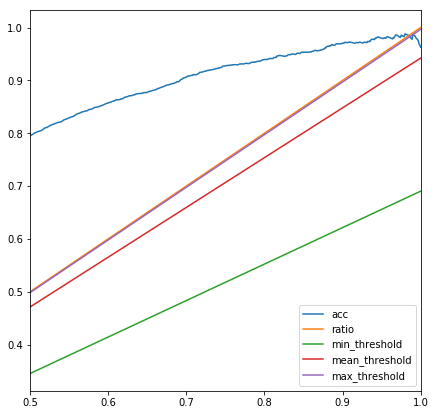

In [186]:
plt.figure()
#results.drop(['num_predictions', 'min_label_predictions', 'mean_label_predictions','max_label_predictions', 'num_labels_misclassified'], axis=1).plot(figsize=(14, 14))
results[['acc', 'ratio', 'min_threshold', 'mean_threshold', 'max_threshold']].plot(figsize=(7, 7))

In [164]:
results[results['acc'] == results['acc'].max()]

,ratio,num_predictions,min_label_predictions,mean_label_predictions,max_label_predictions,num_labels_misclassified,min_missclassification_ratio,mean_missclassification_ratio,max_missclassification_ratio,min_threshold,mean_threshold,max_threshold,acc
0.98,0.98,170.0,1.0,6.538462,49.0,2.0,0.833333,0.988095,1.0,0.67654,0.923361,0.976672,0.988235


<Figure size 432x288 with 0 Axes>

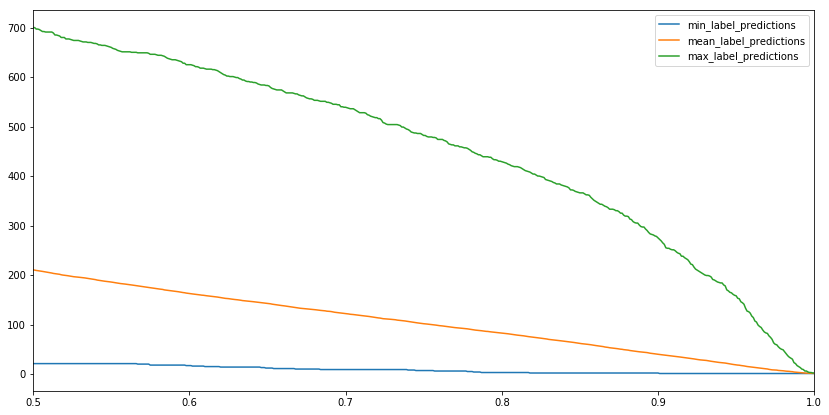

In [188]:
plt.figure()
results[['min_label_predictions', 'mean_label_predictions','max_label_predictions']].plot(figsize=(14, 7))

In [153]:
results[['num_predictions', 'min_label_predictions', 'mean_label_predictions','max_label_predictions', 'num_labels_misclassified']]

,num_predictions,min_label_predictions,mean_label_predictions,max_label_predictions,num_labels_misclassified
0.500,5684.0,21.0,210.518519,700.0,27.0
0.501,5666.0,21.0,209.851852,700.0,27.0
0.502,5650.0,21.0,209.259259,697.0,27.0
0.503,5638.0,21.0,208.814815,697.0,27.0
0.504,5626.0,21.0,208.370370,696.0,27.0
...,...,...,...,...,...
0.996,44.0,1.0,1.692308,4.0,1.0
0.997,40.0,1.0,1.538462,3.0,1.0
0.998,32.0,1.0,1.230769,3.0,1.0
0.999,30.0,1.0,1.153846,2.0,1.0


In [213]:
dynamic_threshold = get_dynamic_threshold(preds, prob, 0.98)
mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)

equal_mask = test_y == preds
unequal_mask = test_y != preds

np.mean(test_y[mask] == preds[mask])

0.9939759036144579

In [214]:
label_probs = {}
for l in np.unique(preds):
    label_probs[l] = prob[preds == l].max()

In [215]:
sorted([(k, v) for k, v in label_probs.items()], key=lambda i: i[1])

[(18, 0.6896078501452859),
 (21, 0.7364661673671717),
 (2, 0.8814659985222689),
 (5, 0.8953446236143634),
 (14, 0.9273952699588239),
 (26, 0.9289995402701031),
 (19, 0.9310682119002379),
 (24, 0.938119711685579),
 (1, 0.9434954590803889),
 (23, 0.9459415460800432),
 (4, 0.9508487278392703),
 (25, 0.9584175513469014),
 (9, 0.9613176400638617),
 (93, 0.9626102093535697),
 (13, 0.963123911223074),
 (20, 0.967981557171511),
 (7, 0.971633024904646),
 (17, 0.9753401708390936),
 (8, 0.9771429356974877),
 (91, 0.9812369602912963),
 (6, 0.9856580712536424),
 (15, 0.9864485453898593),
 (10, 0.9887463032906986),
 (92, 0.9921749477049363),
 (3, 0.9925817127392792),
 (16, 0.9945413723662959),
 (12, 0.9971232826743743)]

In [197]:
(validation_y[np.all([equal_mask, mask], axis=0)].value_counts() / validation_y[mask].value_counts()).sort_values(ascending=False)

93    1.000000
15    1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
7     1.000000
9     1.000000
10    1.000000
12    1.000000
13    1.000000
92    1.000000
14    1.000000
16    1.000000
17    1.000000
18    1.000000
19    1.000000
20    1.000000
21    1.000000
23    1.000000
24    1.000000
26    1.000000
91    1.000000
1     1.000000
6     0.857143
8     0.833333
Name: agg_label, dtype: float64

In [217]:
test_y[np.all([equal_mask, mask], axis=0)].value_counts()

12    48
16    20
92    16
3     15
8      9
10     9
4      6
6      5
20     5
14     4
9      4
15     3
26     3
23     3
93     2
17     2
13     1
18     1
19     1
21     1
7      1
24     1
5      1
25     1
91     1
2      1
1      1
Name: agg_label, dtype: int64

In [208]:
validation_y[mask].value_counts()

12    49
92    17
3     15
16    10
91     8
15     8
6      7
8      6
10     6
20     6
9      5
23     5
4      4
14     3
26     3
17     3
13     2
2      2
21     2
24     2
7      2
93     1
5      1
18     1
19     1
1      1
Name: agg_label, dtype: int64

In [173]:
sorted_dynamic_thresholds = sorted([(k, v) for k, v in dynamic_threshold.items()], key=lambda i: i[1])

sum([x for _,x in sorted_dynamic_thresholds]) / len(sorted_dynamic_thresholds)

0.9422055564593252